In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer

In [2]:
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.circuit.library import MCXGate
from qiskit.visualization import plot_distribution, plot_histogram


In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        if zero_inds:
           qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        if zero_inds:
           qc.x(zero_inds)

    qc.barrier()
    return qc


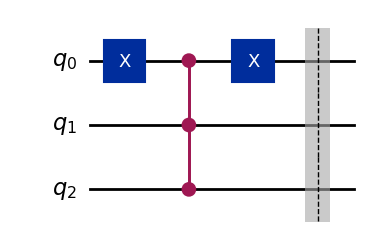

In [4]:
marked_states = ["110"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

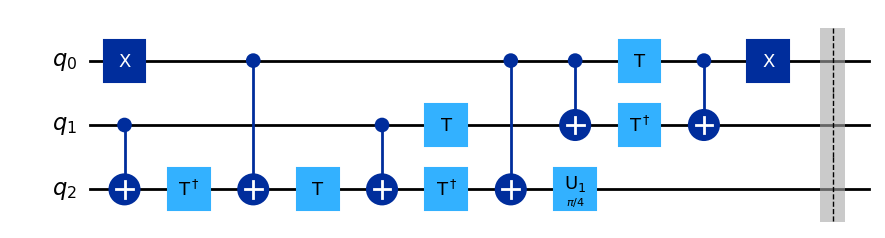

In [5]:
# Descomposición del circuito
basis_gates = ['u1', 'u2', 'u3', 'cx', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg']
decomposed_qc = transpile(oracle, basis_gates=basis_gates)
# Dibujar el circuito descomposto
decomposed_qc.draw('mpl', style="iqp")

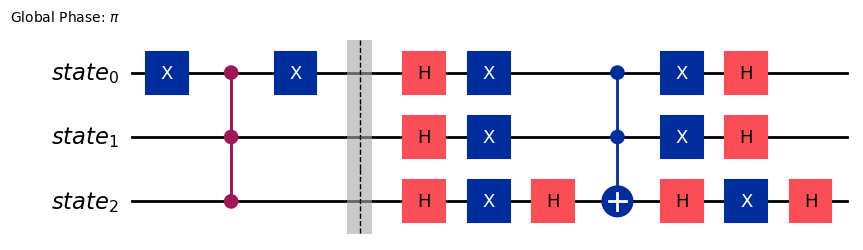

In [6]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [7]:
import sympy as sp
from IPython.display import display, Math


# Definir las variables
pi = sp.pi
asin = sp.asin
sqrt = sp.sqrt
floor = sp.floor
len_marked_states = sp.Symbol('marked')
grover_op_num_qubits = sp.Symbol('qubits')

# Crear la expresión
expression = pi / 4 * sqrt(2**grover_op_num_qubits / len_marked_states )

# Convertir la expresión a LaTeX
latex_expression = sp.latex(expression)

display(Math(latex_expression))

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits))))

print("Optimal num Iterations:", optimal_num_iterations)


<IPython.core.display.Math object>

Optimal num Iterations: 2


Optimo: 2


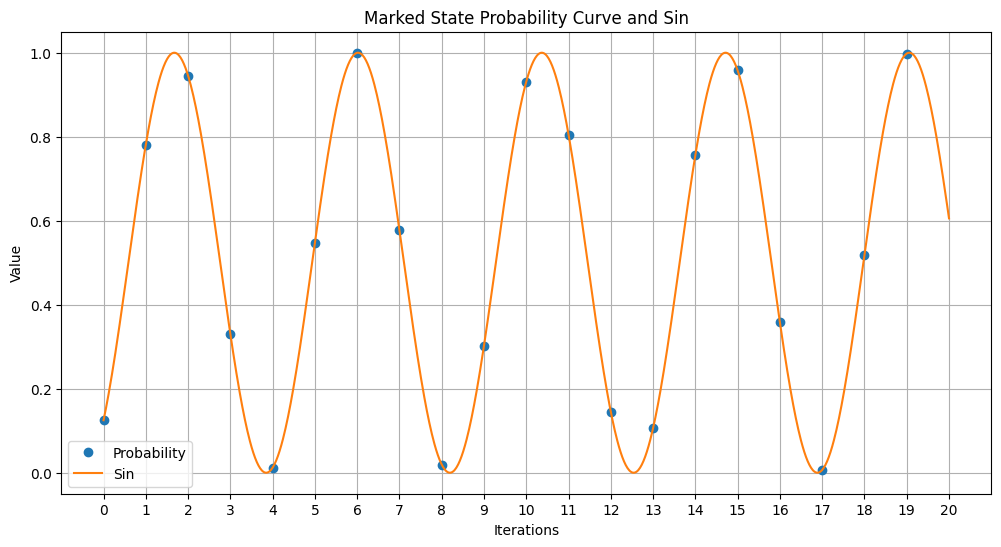

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt


def optimal_iterations(num_qubits, num_marked_states):
    N = 2 ** num_qubits
    iterations = math.floor((math.pi / 4) * math.sqrt(N / num_marked_states))
    return iterations

def probability_of_success(iterations, num_qubits, num_marked_states):
    # Calcular theta
    theta = math.asin(math.sqrt(num_marked_states / (2 ** num_qubits)))

  # Calcular la probabilidad de éxito
    probability = math.sin((2 * iterations +1) * theta) ** 2
    return probability

# Function to calculate the probability of measuring a marked state
def marked_state_probability(iterations, num_qubits, num_marked_states):
    return (math.sin((2 * iterations + 1) * math.acos(math.sqrt(num_marked_states / (2 ** num_qubits)))) ** 2)

# Example values
num_qubits = grover_op.num_qubits
num_marked_states = len(marked_states)
max_iterations = 20

print("Optimo:", optimal_iterations(num_qubits, num_marked_states))

# Calculate probabilities for each iteration
iterations = np.arange(0, max_iterations)
probabilities = [probability_of_success(iteration, num_qubits, num_marked_states) for iteration in iterations]

# Calculate sin values for a denser set of iterations
dense_iterations = np.linspace(0, max_iterations, 1000)
sin_values = [probability_of_success(iteration, num_qubits, num_marked_states) for iteration in dense_iterations]

# Ajuste del tamaño de la figura
plt.figure(figsize=(12, 6))  # Ancho de 12 pulgadas, alto de 6 pulgadas

# Plot the curves
plt.plot(iterations, probabilities, 'o', label='Probability')
plt.plot(dense_iterations, sin_values, label='Sin')

plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Marked State Probability Curve and Sin')
plt.xticks(range(max_iterations + 1))
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import math
def probability_of_success(num_qubits, num_marked_states, iterations):
   # Calcular theta
  theta = math.asin(math.sqrt(num_marked_states / (2 ** num_qubits)))

  # Calcular la probabilidad de éxito
  probability = math.sin((2 * iterations + 1) * theta) ** 2
  return probability

# Ejemplo de uso
num_qubits = grover_op.num_qubits
num_marked_states = len(marked_states)
iterations = 8

# Número de iteraciones
for i in range(iterations): print(i, "ite:", probability_of_success(num_qubits, num_marked_states, i))



0 ite: 0.12500000000000003
1 ite: 0.7812500000000001
2 ite: 0.9453124999999999
3 ite: 0.330078125
4 ite: 0.01220703125000009
5 ite: 0.5479736328125003
6 ite: 0.9997863769531249
7 ite: 0.5769729614257806


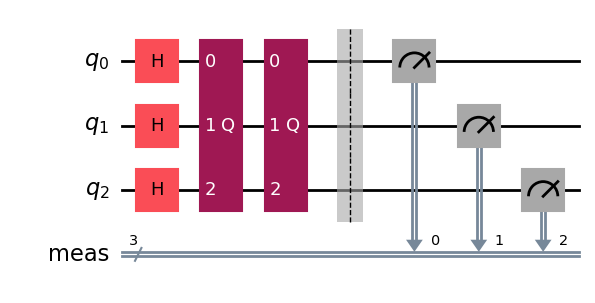

In [10]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

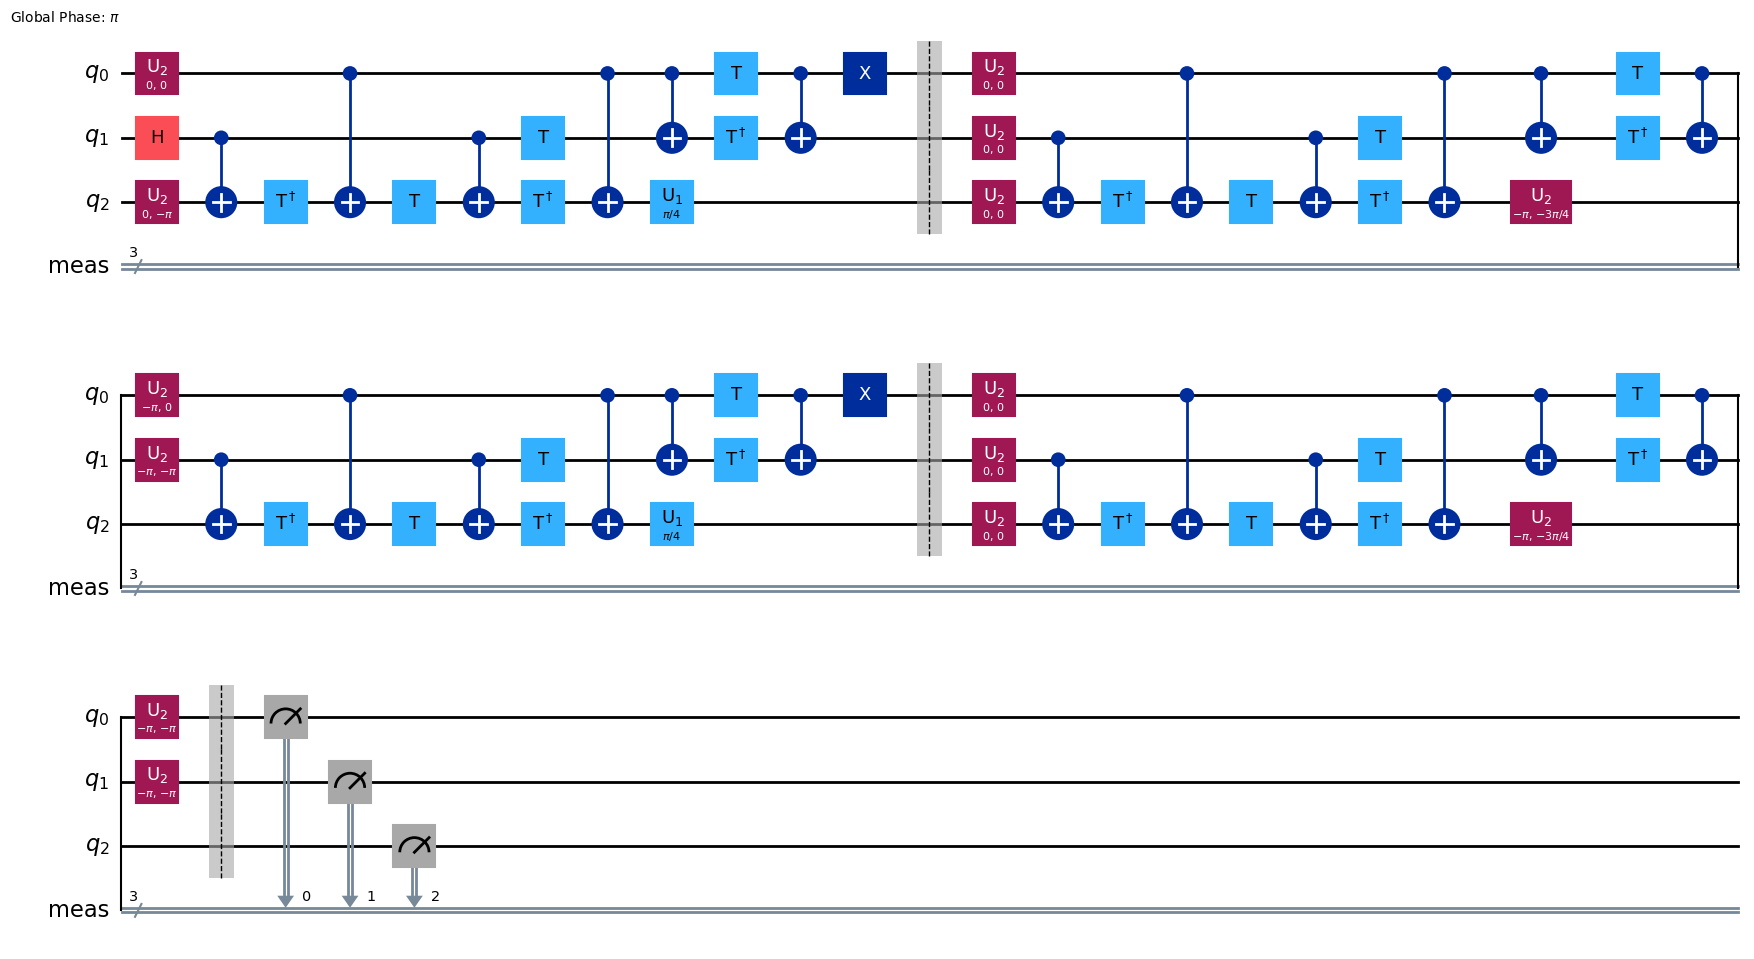

In [11]:
# Descomposición del circuito
basis_gates = ['u1', 'u2', 'u3', 'cx', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg']
decomposed_qc = transpile(qc, basis_gates=basis_gates)
# Dibujar el circuito descomposto
decomposed_qc.draw('mpl', style="iqp")

{'100': 18, '001': 13, '111': 12, '011': 20, '000': 19, '010': 8, '101': 16, '110': 1918}


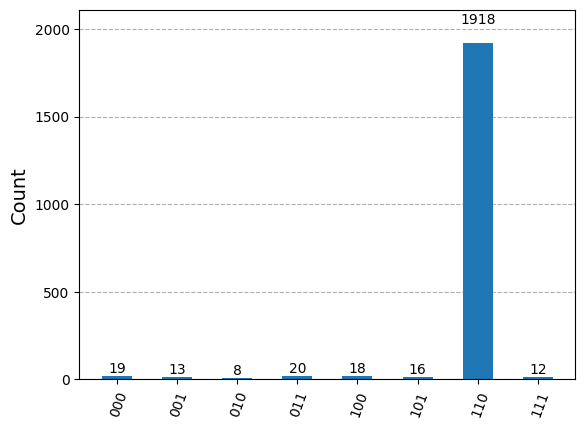

In [12]:
# Usar el simulador qasm_simulator de Aer
simulator = Aer.get_backend('qasm_simulator')

# Compilar y ensamblar el circuito cuántico
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=2024)

result = job.result()
counts = result.get_counts(qc)
print(counts)

plot_histogram(counts)